In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mp
import matplotlib.pyplot as plt
import math as m
import sympy as smp
from IPython.display import display as disp
import lablib as ll
%matplotlib inline
mp.rc("savefig", dpi=96)

Загружаем данные, приводим к СИ.

In [2]:
data, columns, experiments = ll.read_standard_layout()

for e in experiments:
    ll.compute(name = "P",
               expr = lambda P: P * 6/400 * ll.at,
               data = data[e],
               columns = columns[e])
    ll.compute(name = "T",
               expr = lambda T: T + 273,
               data = data[e],
               columns = columns[e])

Получаем зависимость чувствительности термопары ($\frac{\partial U}{\partial T}$) от температуры, считая эту зависимость линейной: $\frac{\partial U}{\partial T} = \frac{\partial^2 U}{\partial T^2} T + (\frac{\partial U}{\partial T})_{T=0}$

Initial guesses for tc_dV_dT:
                Value    Error  ErrorRel
_tc_ddV_dTT 0.000083 0.000001  0.013221
_tc_dV_dT_0 0.015883 0.000357  0.022478


'Final guesses for tc_dV_dT:'

,Value,Error,ErrorRel
_tc_ddV_dTT,0.000083,0.000001,1.38%
_tc_dV_dT_0,0.015844,0.000374,2.36%


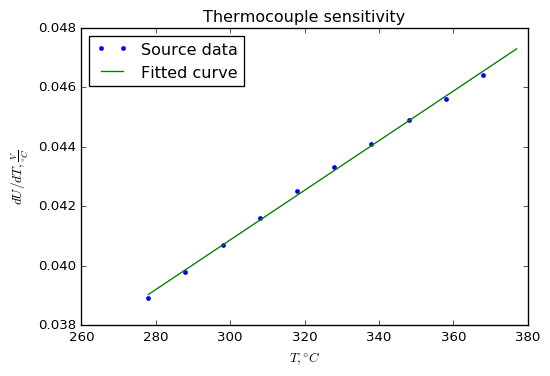

In [3]:
# linear-fit the thermocouple sensitivity

# из лабника
tc_T =     [ x + 273  for x in [5,    15,   25,   35,   45,   55,   65,    75,  85,   95] ]
tc_dV_dT = [ x / 1000 for x in [38.9, 39.8, 40.7, 41.6, 42.5, 43.3, 44.1, 44.9, 45.6, 46.4] ]

tc_model = ll.fit2(name = "tc_dV_dT",
            model = lambda T, _tc_ddV_dTT, _tc_dV_dT_0: T * _tc_ddV_dTT + _tc_dV_dT_0,
            data = data["global"],
            x = tc_T,
            y = tc_dV_dT,
            xerr = [5 for x in tc_T],
            yerr = [0.0001 for x in tc_dV_dT])
tc_T_linspace = ll.linspace(tc_T)

for e in experiments:
    ll.add(data[e], data["global"].loc[["_tc_ddV_dTT", "_tc_dV_dT_0"]])

plt.title("Thermocouple sensitivity")
plt.xlabel("$T, \\degree C$")
plt.ylabel("$dU/dT, \\frac{V}{\\degree C}$")
plt.errorbar(x = tc_T,
             y = tc_dV_dT,
             linestyle = "",
             marker = ".",
             label = "Source data")
plt.errorbar(x = tc_T_linspace,
             y = tc_model(tc_T_linspace),
             label = "Fitted curve")
plt.axis([None, None, None, None])
plt.legend(loc = "best")
plt.show()

Получив модель чувствительности термопары, вычисляем $\Delta T = T_{изм} - T_{терм}$ для каждого измерения двумя способами:
1. Решая линейное уравнение $U = \frac{\partial U}{\partial T} \Delta T$, т. е. пренебрегая изменением чувствительности (считая, что $T_{изм} = T_{терм}$)
2. Решая квадратное уравнение $U = \frac{\partial^2 U}{\partial T^2} T_{изм} \Delta T + \frac{\partial U}{\partial T}_{T=0} \Delta T$

Можно видеть, что различия между полученными значениями лежат в пределах погрешности.

In [4]:
def dT_uncorrected(U, T, _tc_ddV_dTT, _tc_dV_dT_0):
    dV_dT = T * _tc_ddV_dTT + _tc_dV_dT_0
    return U / dV_dT

def dT_corrected(U, T, _tc_ddV_dTT, _tc_dV_dT_0):
    b = _tc_dV_dT_0 - _tc_ddV_dTT * T
    a = _tc_ddV_dTT
    c = - (U + T * _tc_dV_dT_0)

    #dT1 = (-b - (b**2-4*a*c)**(1/2)) / (2*a)
    dT2 = (-b + (b**2-4*a*c)**(1/2)) / (2*a)
    
    return dT2 - T

for e in experiments:
    ll.compute(name = "deltaT",
               expr = dT_uncorrected,
               data = data[e],
               columns = columns[e])
    ll.compute(name = "deltaT_c",
               expr = dT_corrected,
               data = data[e],
               columns = columns[e])
    print("Experiment %s:" % e)
    disp(data[e])
    disp(columns[e])

Experiment T=25:


,Value,Error,ErrorRel
C_p,47.300000,0.500000,1.06%
T,298.250000,0.250000,0.08%
_tc_ddV_dTT,0.000083,0.000001,1.38%
_tc_dV_dT_0,0.015844,0.000374,2.36%


,P,Error_P,ErrorRel_P,U,Error_U,ErrorRel_U,deltaT,Error_deltaT,ErrorRel_deltaT,deltaT_c,Error_deltaT_c,ErrorRel_deltaT_c
0,366278.377500,1470.997500,0.40%,-0.112000,0.000500,-0.45%,-2.750760,0.036502,-1.33%,-2.766435,0.036968,-1.34%
1,323619.450000,1470.997500,0.45%,-0.096000,0.000500,-0.52%,-2.357795,0.031921,-1.35%,-2.369292,0.032267,-1.36%
2,276547.530000,1470.997500,0.53%,-0.079000,0.000500,-0.63%,-1.940268,0.027179,-1.40%,-1.948041,0.027419,-1.41%
3,233888.602500,1470.997500,0.63%,-0.063000,0.000500,-0.79%,-1.547303,0.022906,-1.48%,-1.552238,0.023065,-1.49%
4,186816.682500,1470.997500,0.79%,-0.046000,0.000500,-1.09%,-1.129777,0.018712,-1.66%,-1.132403,0.018805,-1.66%
5,147099.750000,1470.997500,1.00%,-0.032000,0.000500,-1.56%,-0.785932,0.015725,-2.00%,-0.787201,0.015778,-2.00%


Experiment T=40:


,Value,Error,ErrorRel
C_p,47.300000,0.500000,1.06%
T,313.025000,0.025000,0.01%
_tc_ddV_dTT,0.000083,0.000001,1.38%
_tc_dV_dT_0,0.015844,0.000374,2.36%


,P,Error_P,ErrorRel_P,U,Error_U,ErrorRel_U,deltaT,Error_deltaT,ErrorRel_deltaT,deltaT_c,Error_deltaT_c,ErrorRel_deltaT_c
0,367749.375000,1470.997500,0.40%,-0.027000,0.000500,-1.85%,-0.643652,0.014344,-2.23%,-0.644477,0.014382,-2.23%
1,325090.447500,1470.997500,0.45%,-0.013000,0.000500,-3.85%,-0.309906,0.012523,-4.04%,-0.310098,0.012539,-4.04%
2,279489.525000,1470.997500,0.53%,0.001000,0.000500,50.00%,0.023839,0.011923,50.02%,0.023838,0.011922,50.01%
3,229475.610000,1470.997500,0.64%,0.017000,0.000500,2.94%,0.405262,0.012935,3.19%,0.404936,0.012914,3.19%
4,188287.680000,1470.997500,0.78%,0.030000,0.000500,1.67%,0.715169,0.014856,2.08%,0.714155,0.014812,2.07%
5,147099.750000,1470.997500,1.00%,0.040000,0.000500,1.25%,0.953558,0.016788,1.76%,0.951757,0.016721,1.76%


Experiment T=70:


,Value,Error,ErrorRel
C_p,47.300000,0.500000,1.06%
T,343.000000,0.010000,0.00%
_tc_ddV_dTT,0.000083,0.000001,1.38%
_tc_dV_dT_0,0.015844,0.000374,2.36%


,P,Error_P,ErrorRel_P,U,Error_U,ErrorRel_U,deltaT,Error_deltaT,ErrorRel_deltaT,deltaT_c,Error_deltaT_c,ErrorRel_deltaT_c
0,366278.377500,1470.997500,0.40%,0.041000,0.000500,1.22%,0.922429,0.015947,1.73%,0.920838,0.015890,1.73%
1,323619.450000,1470.997500,0.45%,0.051000,0.000500,0.98%,1.147412,0.018006,1.57%,1.144952,0.017925,1.57%
2,279489.525000,1470.997500,0.53%,0.062000,0.000500,0.81%,1.394893,0.020462,1.47%,1.391261,0.020349,1.46%
3,235359.600000,1470.997500,0.62%,0.071000,0.000500,0.70%,1.597377,0.022576,1.41%,1.592618,0.022433,1.41%
4,189758.677500,1470.997500,0.78%,0.078000,0.000500,0.64%,1.754865,0.024269,1.38%,1.749125,0.024099,1.38%
5,148570.747500,1470.997500,0.99%,0.081000,0.000500,0.62%,1.822360,0.025004,1.37%,1.816171,0.024823,1.37%


Для каждой серии экспериментов построим график $\Delta T(\Delta P)$, приблизим его прямой и найдём $\mu_{д-т} = \frac{\partial T}{\partial P}$.

Experiment T=25:
Initial guesses for deltaT:
           Value    Error  ErrorRel
dT_dP -0.000009 0.000000 -0.015021
T_0    0.534659 0.030124  0.056342


'Final guesses for deltaT:'

,Value,Error,ErrorRel
dT_dP,-0.000009,0.000000,-0.50%
T_0,0.536940,0.010499,1.96%


Experiment T=40:
Initial guesses for deltaT:
           Value    Error  ErrorRel
dT_dP -0.000007 0.000000 -0.010770
T_0    2.077820 0.021733  0.010459


'Final guesses for deltaT:'

,Value,Error,ErrorRel
dT_dP,-0.000007,0.000000,-1.85%
T_0,2.075067,0.037000,1.78%


Experiment T=70:
Initial guesses for deltaT:
           Value    Error  ErrorRel
dT_dP -0.000004 0.000000 -0.025272
T_0    2.573111 0.032445  0.012609


'Final guesses for deltaT:'

,Value,Error,ErrorRel
dT_dP,-0.000004,0.000000,-7.49%
T_0,2.571902,0.095398,3.71%


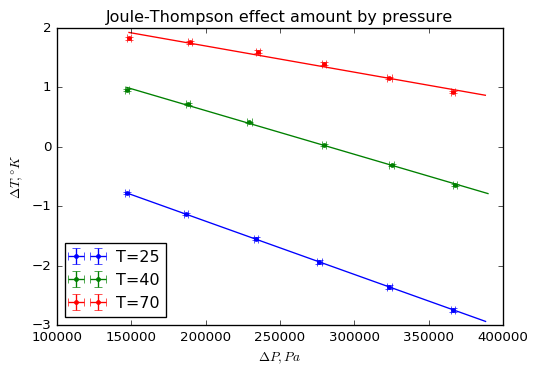

In [5]:
plt.title("Joule-Thompson effect amount by pressure")
plt.xlabel("$\Delta P, Pa$")
plt.ylabel("$\Delta T, \degree K$")

for e in experiments:
    plt.errorbar(x = columns[e]["P"],
                 y = columns[e]["deltaT"],
                 xerr = columns[e]["Error_P"],
                 yerr = columns[e]["Error_deltaT"],
                 linestyle = "none",
                 marker = ".",
                 label = e)
    
plt.gca().set_prop_cycle(None)
    
for e in experiments:
    print("Experiment %s:" % e)

    model = ll.fit2(name = "deltaT",
                    model = lambda P, dT_dP, T_0: P * dT_dP + T_0,
                    x = columns[e]["P"],
                    y = columns[e]["deltaT"],
                    xerr = columns[e]["Error_P"],
                    yerr = columns[e]["Error_deltaT"],
                    data = data[e])
    
    P_linspace = ll.linspace(columns[e]["P"])
    
    plt.plot(P_linspace,
             model(P_linspace))
    
plt.axis([None, None, None, None])
plt.legend(loc = "best")
plt.show()

Теперь построим график зависимости $\mu_{д-т}(T)$. Из теоретических соображений $\mu_{д-т}(T) = \frac{\frac{2a}{RT} - b}{C_p} = \frac{2a}{R C_p} \frac{1}{T} - \frac{b}{C_p}$, поэтому приблизим его гиперболой и найдём оба коэффициента.

Initial guesses for dT_dP:
             Value    Error  ErrorRel
_2a_RCp -0.010277 0.000595 -0.057857
_b_Cp   -0.000026 0.000002 -0.077657


'Final guesses for dT_dP:'

,Value,Error,ErrorRel
_2a_RCp,-0.010280,0.000141,-1.37%
_b_Cp,-0.000026,0.000000,-1.84%


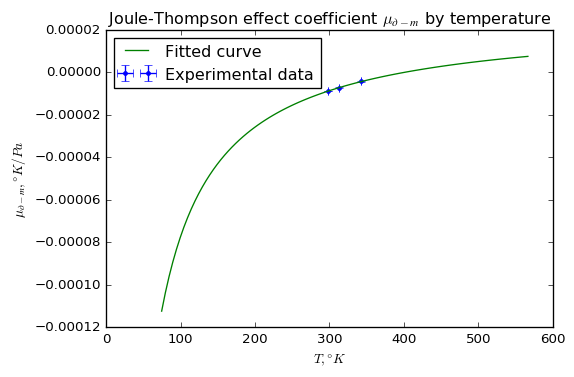

In [6]:
plt.title("Joule-Thompson effect coefficient $\mu_{д-т}$ by temperature")
plt.xlabel("$T, \\degree K$")
plt.ylabel("$\mu_{д-т}, \\degree K / Pa$")

e = "global"

#experiments2 = ["T=40", "T=70"]
#experiments2 = ["T=25", "T=40"]
experiments2 = experiments

ll.make_column(columns[e], "T", data, experiments2)
ll.make_column(columns[e], "dT_dP", data, experiments2)

plt.errorbar(x = columns[e]["T"],
             y = columns[e]["dT_dP"],
             xerr = columns[e]["Error_T"],
             yerr = columns[e]["Error_dT_dP"],
             linestyle = "none",
             marker = ".",
             label = "Experimental data")

model = ll.fit2(name = "dT_dP",
                model = lambda T, _2a_RCp, _b_Cp: _2a_RCp / T - _b_Cp,
                x = columns[e]["T"],
                y = columns[e]["dT_dP"],
                xerr = columns[e]["Error_T"],
                yerr = columns[e]["Error_dT_dP"],
                data = data[e])

T_linspace = ll.linspace(columns[e]["T"], pre = 5, post = 5)

plt.plot(T_linspace,
         model(T_linspace),
         label = "Fitted curve")

plt.axis([None, None, None, None])
plt.legend(loc = "best")
plt.show()

Наконец, вычислим коэффициенты газа Ван-дер-Ваальса $a$ и $b$, а также температуру инверсии $T_{inv}$.

In [7]:
ll.compute(name = "a",
           expr = lambda _2a_RCp, C_p: _2a_RCp * ll.R * C_p / 2,
           data = data[e])
ll.compute(name = "b",
           expr = lambda _b_Cp, C_p: _b_Cp * C_p,
           data = data[e])
ll.compute(name = "T_inv",
           expr = lambda a, b: 2 * a / (ll.R * b),
           data = data[e])

disp(data[e].loc[["a", "b", "T_inv"]])

,Value,Error,ErrorRel
a,-2.021375,0.034996,-0.017313
b,-0.001207,0.000026,-0.021185
T_inv,402.890402,11.022989,0.027360
